In [1]:
%matplotlib inline

import os
from shutil import copyfile, move
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .getOrCreate()




In [3]:
transformed_table = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")

In [2]:
ResNet50_Folder = "/project/ds5559/BioNerds/saved_data/ResNet50_testing/"

In [3]:
training_flder = ResNet50_Folder + "training/"
test_flder = ResNet50_Folder + "test/"
checkpoint_path = "checkpoint_model/cp.ckpt"
checkpoint_dir = os.path.join(ResNet50_Folder,checkpoint_path)

# split transformed_table to training set and test set by dx value.
# using stratified split by ratio 0.8:0.2

In [6]:
dx_table = transformed_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count()
dx_table.show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [7]:
fractions = transformed_table.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [8]:
training_set = transformed_table.stat.sampleBy("dx",fractions, seed=314)
training_set.cache()
test_set = transformed_table.subtract(training_set)
test_set.cache()

DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, pcaFeatures: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, Feature_vec: vector]

In [9]:
training_set.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|         pcaFeatures|indexed_dx|indexed_sex|indexed_loc|         Feature_vec|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0027564|HAM_0004826|ISIC_0027564| nv|follow_up|45.0|  male|        genital|[0.0,0.0,0.0,0.0,...|[-67.127555823468...|       0.0|        0.0|       13.0|[-67.127555823468...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0025753|HAM_0004912|ISIC_0025753|bkl| confocal|70.0|  male|     

In [10]:
test_set.show(5)

+--------------------+--------------------+------------+-----------+------------+-----+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id|   dx|  dx_type| age|   sex|   localization|          features_2|         pcaFeatures|indexed_dx|indexed_sex|indexed_loc|         Feature_vec|
+--------------------+--------------------+------------+-----------+------------+-----+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0029039|HAM_0004317|ISIC_0029039|   df|    histo|50.0|female|lower extremity|[0.0,0.0,0.0,0.0,...|[82.5500326269682...|       6.0|        1.0|        1.0|[82.5500326269682...|
|file:/project/ds5...|[0.0, 0.0, 0.0848...|ISIC_0025584|HAM_0000791|ISIC_0025584|  bcc|    histo|80.0|  

# create training and test folders

#### make training folder

In [ ]:
os.mkdir(training_flder)
os.mkdir(test_flder)

In [51]:
for row in dx_table.rdd.collect():
    training_folder = training_flder + row[0] + "_" + str(int(row[1]))
    #print(training_folder)
    os.mkdir(training_folder)

In [42]:
training_info = training_set.rdd.map(lambda x: (x.image_id, x.dx, x.indexed_dx , x.path)).collect()

In [61]:
for f in enumerate(training_info):
    org = f[1][3][5:]
    dest = training_flder+f[1][1]+"_"+str(int(f[1][2]))

    copyfile(os.path.join(org), os.path.join(dest, f[1][0]+".jpg" ))


#### make test folders

In [62]:
for row in dx_table.rdd.collect():
    test_folder = test_flder + row[0] + "_" + str(int(row[1]))
    os.mkdir(test_folder)

In [12]:
test_info = test_set.rdd.map(lambda x: (x.image_id, x.dx, x.indexed_dx , x.path)).collect()

In [13]:
for f in enumerate(test_info):
    org = f[1][3][5:]
    dest = test_flder+f[1][1]+"_"+str(int(f[1][2]))

    copyfile(os.path.join(org), os.path.join(dest, f[1][0]+".jpg"))


# prepare training and test datasets

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(training_flder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 7978 files belonging to 7 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['akiec_4', 'bcc_3', 'bkl_2', 'df_6', 'mel_1', 'nv_0', 'vasc_5']


In [6]:
#train_dataset.class_names_index

In [7]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [8]:
validation_dataset = image_dataset_from_directory(test_flder,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1970 files belonging to 7 classes.


# show the first nine images and labels from the training set

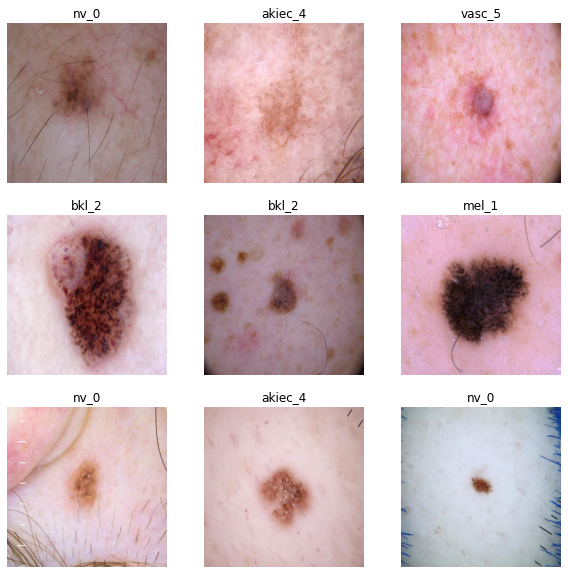

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### move 20% of them to as test set

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 50
Number of test batches: 12


### configure the dataset for performace

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### use data augmentation, rotating images

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

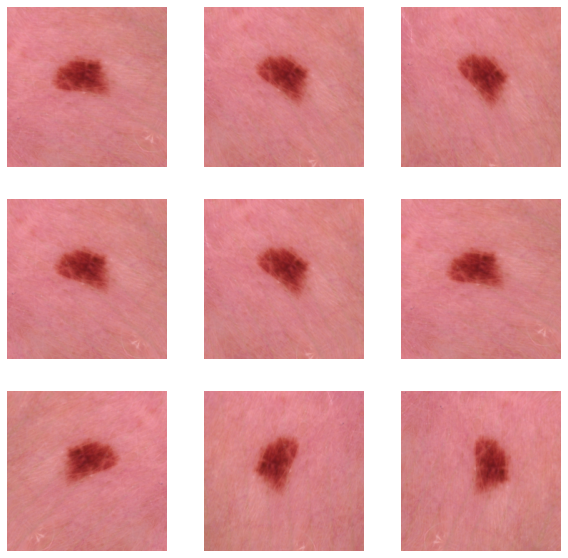

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Load Keras pre-trained ResNet50 as a base model

In [13]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),include_top=False, weights='imagenet')

In [14]:
base_model.trainable = False
#base_model.summary()

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


## Create a new model from ResNet50 base model

In [18]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### only the top layer is trainable

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
____________________________________________

In [21]:
len(model.trainable_variables)

2

#### accuracy of the model without training

In [22]:
initial_epochs = 10

In [23]:
loss0, accuracy0 = model.evaluate(validation_dataset)

50/50 [==============================] - 48s 919ms/step - loss: 1.8906 - accuracy: 0.2333


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.89
initial accuracy: 0.23


In [25]:
checkpoint_path = "checkpoint_model/cp.ckpt"
checkpoint_dir = os.path.join(ResNet50_Folder,checkpoint_path)

#os.mkdir(checkpoint_dir)

In [26]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### traing the top layer of the new model in first 10 epochs 

In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback])

Epoch 1/10
250/250 [==============================] - 283s 1s/step - loss: 0.9988 - accuracy: 0.6739 - val_loss: 0.7068 - val_accuracy: 0.7516

Epoch 00001: saving model to checkpoint_model/cp.ckpt
Epoch 2/10
250/250 [==============================] - 279s 1s/step - loss: 0.8015 - accuracy: 0.7221 - val_loss: 0.6981 - val_accuracy: 0.7585

Epoch 00002: saving model to checkpoint_model/cp.ckpt
Epoch 3/10
250/250 [==============================] - 278s 1s/step - loss: 0.7687 - accuracy: 0.7264 - val_loss: 0.6640 - val_accuracy: 0.7636

Epoch 00003: saving model to checkpoint_model/cp.ckpt
Epoch 4/10
250/250 [==============================] - 280s 1s/step - loss: 0.7381 - accuracy: 0.7341 - val_loss: 0.6437 - val_accuracy: 0.7705

Epoch 00004: saving model to checkpoint_model/cp.ckpt
Epoch 5/10
250/250 [==============================] - 279s 1s/step - loss: 0.7324 - accuracy: 0.7400 - val_loss: 0.6720 - val_accuracy: 0.7554

Epoch 00005: saving model to checkpoint_model/cp.ckpt
Epoch 6/10

### save the model, and training values

In [28]:
model_path = "model"
model_dir = os.path.join(ResNet50_Folder,model_path)
model.save(model_dir)

/home/jh4yd/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /project/ds5559/BioNerds/saved_data/ResNet50_testing/model/assets


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [30]:
history_df = pd.DataFrame({'acc':acc, 'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss})
history_df.to_csv("history_table.csv")

# learning curves

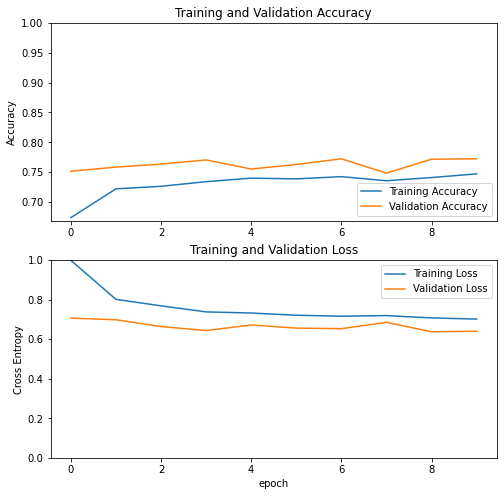

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### load model and training  values

In [35]:
#model_dir = "/project/ds5559/BioNerds/saved_data/ResNet50_testing/model"
#model = tf.keras.models.load_model(model_dir)
#history_csv = pd.read_csv("history_table.csv")
#acc = history_csv['acc'].tolist()
#val_acc = history_csv['val_acc'].tolist()
#loss = history_csv['loss'].tolist()
#val_loss = history_csv['val_loss'].tolist()


# fine tune (base model: from  layer 150 --> 175)

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [34]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [35]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/2),
              #loss='categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 10,004,487
Non-trainable params: 13,597,568
________________________________________

In [37]:
len(model.trainable_variables)

32

#### training(epoch 10-50)

In [38]:
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/50
250/250 [==============================] - 371s 1s/step - loss: 1.1498 - accuracy: 0.7017 - val_loss: 0.6772 - val_accuracy: 0.7724
Epoch 11/50
250/250 [==============================] - 366s 1s/step - loss: 0.7560 - accuracy: 0.7378 - val_loss: 0.6604 - val_accuracy: 0.7667
Epoch 12/50
250/250 [==============================] - 364s 1s/step - loss: 0.7123 - accuracy: 0.7466 - val_loss: 1.1844 - val_accuracy: 0.7497
Epoch 13/50
250/250 [==============================] - 365s 1s/step - loss: 0.6902 - accuracy: 0.7570 - val_loss: 0.7951 - val_accuracy: 0.7352
Epoch 14/50
250/250 [==============================] - 365s 1s/step - loss: 1.1010 - accuracy: 0.7608 - val_loss: 0.7512 - val_accuracy: 0.7617
Epoch 15/50
250/250 [==============================] - 363s 1s/step - loss: 0.6537 - accuracy: 0.7730 - val_loss: 0.5887 - val_accuracy: 0.7913
Epoch 16/50
250/250 [==============================] - 363s 1s/step - loss: 0.6908 - accuracy: 0.7793 - val_loss: 0.6791 - val_accuracy:

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

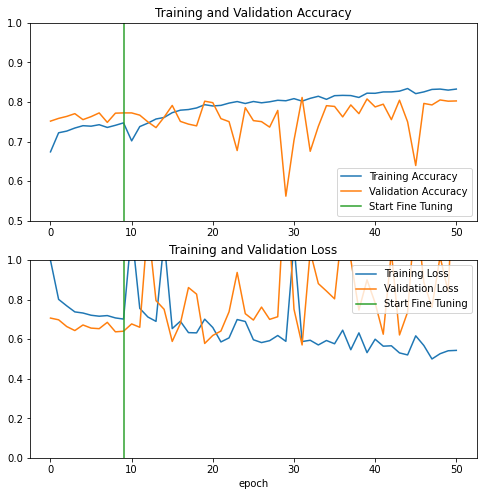

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save the Final Model and traing, validating values

In [41]:
model_path = "Final_model"
model_dir = os.path.join(ResNet50_Folder,model_path)
model.save(model_dir)

/home/jh4yd/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /project/ds5559/BioNerds/saved_data/ResNet50_testing/Final_model/assets


In [42]:
history_df = pd.DataFrame({'acc':acc, 'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss})
history_df.to_csv("history_table.csv")

# Test the model with test set

In [43]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', test_accuracy)

12/12 [==============================] - 11s 889ms/step - loss: 0.9203 - accuracy: 0.7969
Test accuracy : 0.796875


In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [45]:
label = np.concatenate([y for x, y in test_dataset], axis=0)

In [46]:
predictions = model.predict(test_dataset)
y_pred= np.argmax(predictions, axis=1)

In [47]:
cm= confusion_matrix(label,y_pred)
print(cm)

[[  0   2   1   0   0  10   0]
 [  0   0   2   0   2  11   0]
 [  1   2   2   0   4  27   0]
 [  0   0   0   0   0   4   0]
 [  0   2   6   0  12  30   0]
 [  0  16  14   0  36 197   1]
 [  0   0   0   0   1   1   0]]


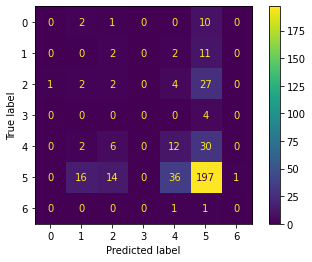

In [48]:
ConfusionMatrixDisplay(cm).plot()